# Pave Classification Project

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns',None)
import os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize']=14,8
import seaborn as sns
from IPython.display import display, Markdown
import pickle

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from imblearn.combine import SMOTETomek
from patsy import dmatrices, dmatrix, demo_data
from treeinterpreter import treeinterpreter as ti

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


Load data files

In [2]:
os.chdir('path')
files = os.listdir()
files
codes = ['a','b','c','d','e']

Create dict of DataFrames

In [5]:
dfs={code:pd.read_csv(filename,delimiter='\t') 
     for code,filename in zip(codes,files)}


## Feature Engineering

Create 'difference' variables for metrics with lagged values

In [6]:
def diffe(df):
    df['durationdif']=df['_metric_ga:sessionDuration0']-df['_metric_ga:sessionDuration1']
    df['sessiondif']=df['_metric_ga:sessions0']-df['_metric_ga:sessions1']
    return(df)

Create city frequency metric from categorical variable 'location:city'

In [7]:
def addcityfreq(df):
    a=pd.DataFrame(df['location:city'].value_counts())
    a.reset_index()
    a['city']=a.index
    a.reset_index()
    a = a.rename(columns={'city': 'location:city', 'location:city': 'cityfreq'})
    b = pd.merge(df,a,how='left',on='location:city')
    return(b)

Create dict of Dataframes that include features created above

In [8]:
dffe = {}
for i in dfs.keys():
    dffe[i]=diffe(addcityfreq(dfs[i]))

Define function for creating one-hot-encoded matrices readable by sklearn

In [9]:
def makexy(df,dictdf='dffe'):
    
    cols = ['_metric_ga:sessionDuration0', 
            '_metric_ga:sessionDuration1',
            '_metric_ga:sessions0', 
            '_metric_ga:sessions1',
            '_metric_ga:transactionRevenue1',
       
            '_metric_ga:transactions1', 
         
            #'date:dayOfWeek', 
            'date:weekend', 
            'ga:operatingSystem',
      
            'ga:userType', 
            #'path:p0',
            'sm:parent',
          
            'cityfreq',
            'durationdif', 
            'sessiondif'
           ]

    if dictdf=='dfs':
        cols = [i for i in cols if i not in ['cityfreq', 'durationdif', 'sessiondif']]
    
    catcols= [#'date:dayOfWeek', 
            'date:weekend', 
            'ga:operatingSystem',
         
            'ga:userType', 
            #'path:p0',
            'sm:parent',
             ]
    
    concols=[i for i in cols if i not in catcols]
    

        
    
    X = df[cols]
    print('X',X.shape)
    y = df['_metric_ga:transactions0']
    y=[1 if i>0 else 0 for i in y ]
    yd=pd.Series(y)
    if concols==[]:
        Xreg=X
    
    else:
        
        conts = df[concols]

        scaler = StandardScaler()
        scaler.fit(conts)
        contsscaled= pd.DataFrame(scaler.transform(conts),columns=concols)

        Xn = contsscaled
        print('Xn',Xn.shape)
        Xcat = X[catcols]
        Xreg = pd.concat([Xn,Xcat],axis=1)
        
    print('Xreg',Xreg.shape)
    
    Xd = pd.get_dummies(Xreg)
    
    
    return(Xd,yd)

Grid search over regularization parameter for Logistic Regression

In [ ]:
clf=LogisticRegression(penalty='l1',solver='liblinear',class_weight='balanced')
param = {'C':[0.001,0.01,0.1,1]}
gsclf = GridSearchCV(clf, param, cv=6)
gsclf.fit(Xdt,ydt)
gsclf.best_params_

Grid search over hyperparameters for Random Forest model for comparison

In [ ]:
clf=RandomForestClassifier()
param = {}
param_grid = {'n_estimators': [10, 100, 1000], 
              'max_features': [10,Xdt.shape[1]],
              'max_depth':[30,60] 
              }

gsclf = GridSearchCV(clf, param_grid, cv=3)
gsclf.fit(Xdt,ydt)
gsclf.best_params_

Define a workflow that splits the data into test, train and validation sets and returns a confusion matrix for test data

In [ ]:
def mypipeline(Xd,yd,clff):
    xdcols = Xd.columns.values.tolist()
    Xtrain, Xtest, ytrain, ytest = train_test_split(Xd,yd,test_size=0.25,stratify=yd)
    
    folds = 6

    skf = StratifiedKFold(n_splits=folds)
    skfind = []
    for tind in skf.split(Xtrain,ytrain):
        skfind.append(tind)

    tprate=0
    recall=0
    for i in range(folds):
        train_indices = skfind[i][0]
        test_indices = skfind[i][1]
        clf = clff
        X_train = Xtrain.iloc[list(train_indices)]
        y_train = np.array(ytrain)[list(train_indices)]
        X_test = Xtrain.iloc[list(test_indices)]
        y_test = np.array(ytrain)[list(test_indices)]
        clf.fit(X_train,y_train) 
        y_predict = []
        y_predict = clf.predict(X_test) # output is labels and not indices

    #cm = []
        cm = confusion_matrix(y_test,y_predict)
        print(i,'***********')
        print(cm)
        print('')
        tpi = cm[1][1]/(cm[1][1]+cm[0][1])
        tprate += tpi
        recalli = cm[1][1]/(cm[1][1]+cm[1][0])
        recall += recalli
        print('tp rate',tpi)
        print('recall',recalli)
    print('TPRATE',tprate/folds)
    print('RECALL',recall/folds)
        

        
    if type(clff) == RandomForestClassifier:
        importances = [[c, i] for c, i in zip(Xd.columns, clff.feature_importances_)];
        importances = sorted(importances, key=lambda x: x[1], reverse = True);
        for j in range(10):
            print(importances[j][0], importances[j][1])
        
    y_predict=clf.predict(Xtest)
    cm = confusion_matrix(ytest,y_predict)
    print('TEST CM')
    print(cm)
    print('')

In [126]:
def mypipelineret(Xd,yd,clff):
    xdcols = Xd.columns.values.tolist()
    Xtrain, Xtest, ytrain, ytest = train_test_split(Xd,yd,test_size=0.25,stratify=yd)
    
    folds = 6

    skf = StratifiedKFold(n_splits=folds)
    skfind = []
    for tind in skf.split(Xtrain,ytrain):
        skfind.append(tind)

    tprate=0
    recall=0
    for i in range(folds):
        train_indices = skfind[i][0]
        test_indices = skfind[i][1]
        clf = clff
        X_train = Xtrain.iloc[list(train_indices)]
        y_train = np.array(ytrain)[list(train_indices)]
        X_test = Xtrain.iloc[list(test_indices)]
        y_test = np.array(ytrain)[list(test_indices)]
        clf.fit(X_train,y_train) 
        y_predict = []
        y_predict = clf.predict(X_test) # output is labels and not indices

    #cm = []
        cm = confusion_matrix(y_test,y_predict)
        print(i,'***********')
        print(cm)
        print('')
        tpi = cm[1][1]/(cm[1][1]+cm[0][1])
        tprate += tpi
        recalli = cm[1][1]/(cm[1][1]+cm[1][0])
        recall += recalli
        print('tp rate',tpi)
        print('recall',recalli)
    print('TPRATE',tprate/folds)
    print('RECALL',recall/folds)
        

        
    if type(clff) == RandomForestClassifier:
        importances = [[c, i] for c, i in zip(Xd.columns, clff.feature_importances_)];
        importances = sorted(importances, key=lambda x: x[1], reverse = True);
        for j in range(10):
            print(importances[j][0], importances[j][1])
        
    y_predict=clf.predict(Xtest)
    cm = confusion_matrix(ytest,y_predict)
    print('TEST CM')
    print(cm)
    print('')
    return(cm)

Define function to implement SMOTE and Tomek Link removal

In [14]:
def smtmk(Xd,yd):

    sm = SMOTETomek()
    X_resampled, y_resampled = sm.fit_sample(Xd, yd)
    print('xrshape',X_resampled.shape)
    return(X_resampled,y_resampled)

Define pipeline incorporating resampled data

In [31]:
def smtmkpl(X_resampled, y_resampled,Xd,yd,clff):
    
    folds = 6
    skf = StratifiedKFold(n_splits=6)
    skf.get_n_splits(X_resampled,y_resampled)
    skfind = []
    for tind in skf.split(X_resampled,y_resampled):
        skfind.append(tind)



    for i in range(folds):
        train_indices = skfind[i][0]
        test_indices = skfind[i][1]
        clf = clff
        #clf.fit(X_resampled,y_resampled)
        X_train = X_resampled[list(train_indices)]
        y_train = np.array(y_resampled)[list(train_indices)]
        X_test = X_resampled[list(test_indices)]
        y_test = np.array(y_resampled)[list(test_indices)]
        clf.fit(X_train,y_train) 
        #y_score = clf.fit(X_train,y_train).decision_function(X_test)
        y_predict = []
        y_predict = clf.predict(X_test) # output is labels and not indices

    #cm = []
        cm = confusion_matrix(y_test,y_predict)
        print(i,'***********')
        #print(cm)
        #print('')   


    Xtrain, Xtest, ytrain, ytest = train_test_split(Xd,yd,test_size=0.25,stratify=yd)

    folds = 6

    skf = StratifiedKFold(n_splits=folds)

    skfind = []
    for tind in skf.split(Xtrain,ytrain):
        skfind.append(tind)

    tprate=0
    recall=0
    
    for i in range(folds):
        train_indices = skfind[i][0]
        test_indices = skfind[i][1]
        X_train = Xtrain.iloc[list(train_indices)]
        y_train = np.array(ytrain)[list(train_indices)]
        X_test = Xtrain.iloc[list(test_indices)]
        print('xtest',X_test.shape)
        y_test = np.array(ytrain)[list(test_indices)]

        y_predict = []
        y_predict = clf.predict(X_test) # output is labels and not indices
        #y_score = clf.decision_function(X_test)

        cm = confusion_matrix(y_test,y_predict)
        print(i,'***********')
        #print(cm)
        #print('')
        tpi = cm[1][1]/(cm[1][1]+cm[0][1])
        tprate += tpi
        recalli = cm[1][1]/(cm[1][1]+cm[1][0])
        recall += recalli
        print('tp rate',tpi)
        print('recall',recalli)
    print('TPRATE',tprate/folds)
    print('RECALL',recall/folds)
    
    if type(clff) == RandomForestClassifier:
        importances = [[c, i] for c, i in zip(Xd.columns, clff.feature_importances_)];
        importances = sorted(importances, key=lambda x: x[1], reverse = True);
        for j in range(min(len(Xd.columns),20)):
            print(importances[j][0], importances[j][1])
    
    else:
        a=clff.coef_!=0
        b=a.reshape(len(a[0]),)
        cnames=Xd.columns[b]
        pd.options.display.max_colwidth = 100
        coeffs=pd.DataFrame(list(zip(cnames,clff.coef_[a])),columns=['nam','val'])
        len(coeffs)
        print(type(coeffs))
        print(coeffs.columns)
        coeffs['nam']
        coeffs = coeffs.assign(abs_A = lambda x: np.abs(x['val']))
        coeffs
        importances = coeffs.sort_values(by='abs_A',ascending=False)
        
        
        
    y_predict=clf.predict(Xtest)
    cm = confusion_matrix(ytest,y_predict)
    print('TEST CM')
    print(cm)
    print('')
    return(cm,importances)

Put together functions into a pipeline that returns feature importances

In [16]:
def mpl(df,clff,dictdf='dffe'):
    (Xd,yd) = makexy(df,dictdf)
    #Xdt,ydt=makexyshort(Xd,yd)
    mypipeline(Xd,yd,clff)
    a=smtmk(Xd,yd)
    smtmkpl(a[0],a[1],Xd,yd,clff)
    cm,importances = smtmkpl(a[0],a[1],Xd,yd,clff)
    return(cm,importances)
    

In [17]:
def make_clf(X_resampled,y_resampled,clff):
    clf = clff
    clf.fit(X_resampled,y_resampled)
    s = pickle.dumps(clf)
    # to return, do clf2 = pickle.loads(s)
    return(s)

In [227]:
names = {'cityfreq':'City Frequency ',
 'ga:operatingSystem_Mobile: iOS':'Mobile OS: iOS ',
 '_metric_ga:sessions1': 'Last Month Sessions' ,
 'ga:userType_New Visitor':'New Visitor ',
 'ga:operatingSystem_Mobile: Android':'Mobile OS: Android ',
 'sm:parent_Social':'Origin: Social ',
 'sm:parent_Organic':'Origin: Organic ',
 'ga:operatingSystem_Desktop: Windows': 'OS: Windows ',
 'ga:userType_Returning Visitor':'Returning Visitor ',
 'ga:operatingSystem_Desktop: Mac':"OS: Mac ",
 '_metric_ga:sessionDuration1':'Last Month Session Duration ',
 'sm:parent_Other':'Origin: Other ',
 'date:dayOfWeek_Tuesday':'Tuesday ',
 'date:dayOfWeek_Wednesday':'Wednesday ',
 'date:dayOfWeek_Monday':'Monday ',
 'date:dayOfWeek_Thursday':'Thursday ',
 'date:weekend':'Weekend ',
 'date:dayOfWeek_Saturday':'Saturday ',
 'date:dayOfWeek_Friday':'Friday ',
 'date:dayOfWeek_Sunday':'Sunday ',
 'ga:operatingSystem_Other':'Mobile OS: Other ',
 '_metric_ga:transactionRevenue1':'Last Month Revenue ',
 '_metric_ga:transactions1':'Last Month Transactions ',
 'ga:operatingSystem_Mobile: Other':'Mobile OS: Other ',
 'sm:parent_Email':'Origin: Email ',
 '_metric_ga:sessionDuration0':'Current Month Session Duration ',
 '_metric_ga:sessions0':'Current Month Sessions ',
 'durationdif':'Duration Change ',
 'sessiondif':'Session Change ',
 'sm:parent_Ads': 'Source: Ads '}

In [221]:
def makexpoly(df):
    df=df.rename(index=str, columns=names)
    pf = PolynomialFeatures(degree=3,interaction_only=True)
    pt = pf.fit_transform(df)
    nam = pf.get_feature_names(input_features=df.columns)
    Xpoly = pd.DataFrame(pt,columns=nam)
    Xpolynozero = Xpoly.loc[:, (Xpoly != 0).any(axis=0)]
    return(Xpolynozero)

Create pipeline for logistic regressions with polynomial features

In [ ]:
%%time
cms={'bal':[],'s':[],'fe':[]}
imps = {}
stats ={'Recall Auto':[],'Precision Auto':[],
        'Recall SMOTE/Tomek':[],'Precision SMOTE/Tomek':[],
        'Recall Feature Engineering':[],'Precision Feature Engineering':[]}

impsfe={}

for i in codes:
    print(i)
    Xd,yd=makexy(dfs[i],dictdf='dfs')
    print(len(Xd))
    Xdtp = makexpoly(Xd)
    cmbal = mypipelineret(Xdtp,ydt,LogisticRegression(penalty='l1',
                                                      solver='liblinear',
                                                      class_weight='balanced',
                                                      C=0.2
                                                     )
                         )
    tp = cmbal[1][1]/(cmbal[1][1]+cmbal[0][1])
    stats['Precision Auto'].append(round(tp,2))
    recall = cmbal[1][1]/(cmbal[1][1]+cmbal[1][0])
    stats['Recall Auto'].append(round(recall,2)) 

    cm, imp = mplpolyshort(dfs[i],
                           LogisticRegression(penalty='l1',
                                                     solver='liblinear',
                                                     C=0.2
                                                    ),
                           dictdf='dfs'
                          )
    cms['s'].append(cm)
    imps[i]=imp
    tp = cm[1][1]/(cm[1][1]+cm[0][1])
    stats['Precision SMOTE/Tomek'].append(round(tp,2))
    print(1,stats)
    recall = cm[1][1]/(cm[1][1]+cm[1][0])
    print('recall',recall)
    stats['Recall SMOTE/Tomek'].append(round(recall,2)) 
    print(2,stats)
    
    cmfe, impfe = mplpolyshort(dffe[i],LogisticRegression(penalty='l1',
                                                          solver='liblinear',
                                                          C=0.2))
    cms['fe'].append(cmfe)
    impsfe[i]=impfe
    tpfe = cmfe[1][1]/(cmfe[1][1]+cmfe[0][1])
    stats['Precision Feature Engineering'].append(round(tpfe,2))
    print(3,stats)
    recallfe = cmfe[1][1]/(cmfe[1][1]+cmfe[1][0])
    stats['Recall Feature Engineering'].append(round(recallfe,2))
    print(4,stats)

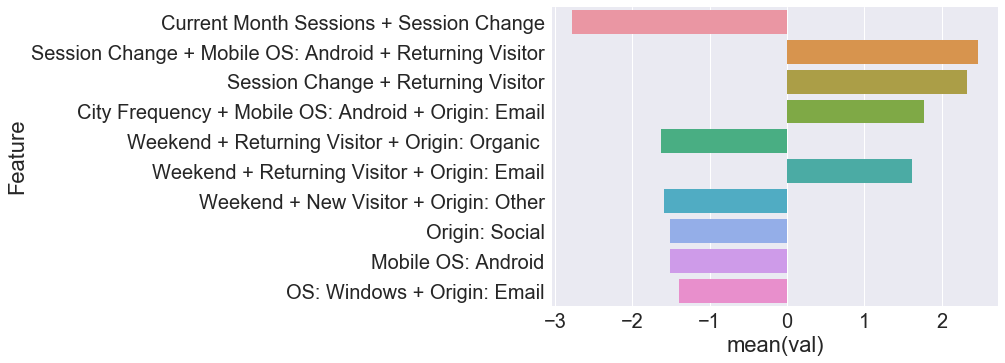

In [439]:
sns.set(font_scale=2)
sns.barplot(x="val", y="Feature", data=a10)

plt.show()

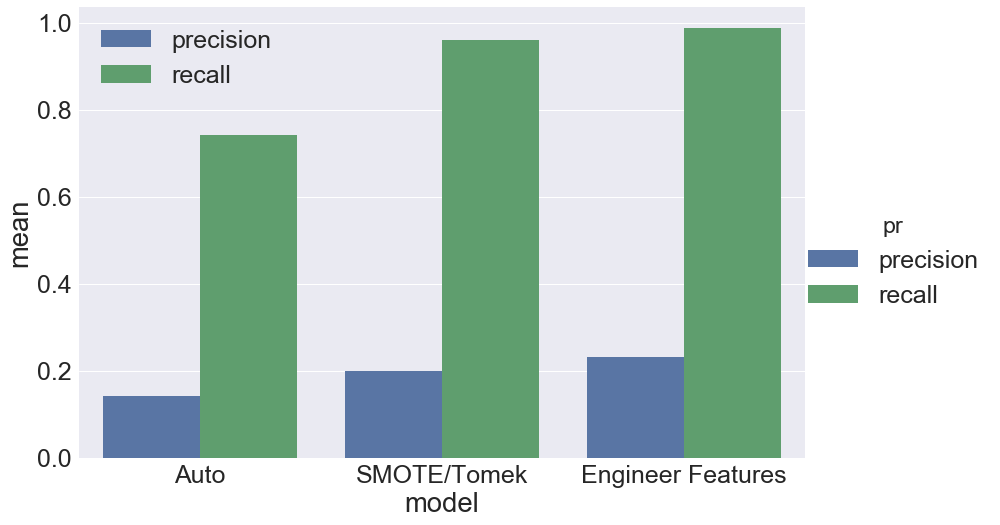

In [440]:
sns.set(font_scale=2.5)
statsdf=pd.DataFrame(stats).T
statsdf['mean']=statsdf.mean(axis=1)
statsdf['pr']=['precision','precision','precision','recall','recall','recall']
statsdf['model']=['Auto','Engineer Features','SMOTE/Tomek','Auto','Engineer Features','SMOTE/Tomek']
statsdf=statsdf.reset_index(drop=True)
sns.factorplot(x='model', 
               y='mean', 
               hue='pr', 
               kind='bar', 
               data=statsdf,
               order=['Auto','SMOTE/Tomek','Engineer Features'],
               size=8, aspect=1.5)
plt.legend(loc='upper left')
plt.show()